In [1]:
# Import packages
import numpy as np
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold

C:\Users\shoyr\anaconda3\envs\fastai_env\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Import image labels
df = pd.read_csv('images/labels.csv')
df.head()

,files,label_specific,label_general,source
0,IMG_3788.JPEG,sweetclem,citrus,self
1,IMG_3789.JPEG,sweetclem,citrus,self
2,IMG_3790.JPEG,sweetclem,citrus,self
3,IMG_3791.JPEG,sweetclem,citrus,self
4,IMG_3792.JPEG,sweetclem,citrus,self


In [3]:
df['labels'] = df[['label_specific','label_general']].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1
)

In [4]:
# Setup image transforms
tfms = aug_transforms(size=224,flip_vert=True, max_rotate=25, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [5]:
'''skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)
conv_nets = [(resnet34,'resnet34'), (resnet50,'resnet50'), (resnet152,'resnet152'),
             (xresnet34,'xresnet34'), (xresnet50, 'xresnet50'), (xresnet152,'xresnet152'),
            (xresnet50_deeper,'xresnet50_deeper')]'''

"skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)\nconv_nets = [(resnet34,'resnet34'), (resnet50,'resnet50'), (resnet152,'resnet152'),\n             (xresnet34,'xresnet34'), (xresnet50, 'xresnet50'), (xresnet152,'xresnet152'),\n            (xresnet50_deeper,'xresnet50_deeper')]"

In [6]:
# Perform cross validtation AND select optimal underlying conv net
# Commented out since resnet152 was already determined to be the best fit for the data
'''results = []

for net, name in conv_nets:
    acc_val = []
    for train_index, val_index in skf.split(df.files, df.labels):
        d = df.copy()
        d.loc[:,'is_valid'] = 0
        d.loc[val_index, 'is_valid'] = 1
        # Load image data from image labels and jpg files
        dls = ImageDataLoaders.from_df(d, 'images', valid_col='is_valid', label_delim=' ',
                                   item_tfms=Resize(224), bs=64, batch_tfms=tfms)
        learn = cnn_learner(dls, net, metrics=partial(accuracy_multi, thresh=0.5))
        learn.fine_tune(1)
        loss, acc = learn.validate()
        acc_val.append(acc)
    results.append([name, np.mean(acc_val)])'''

"results = []\n\nfor net, name in conv_nets:\n    acc_val = []\n    for train_index, val_index in skf.split(df.files, df.labels):\n        d = df.copy()\n        d.loc[:,'is_valid'] = 0\n        d.loc[val_index, 'is_valid'] = 1\n        # Load image data from image labels and jpg files\n        dls = ImageDataLoaders.from_df(d, 'images', valid_col='is_valid', label_delim=' ',\n                                   item_tfms=Resize(224), bs=64, batch_tfms=tfms)\n        learn = cnn_learner(dls, net, metrics=partial(accuracy_multi, thresh=0.5))\n        learn.fine_tune(1)\n        loss, acc = learn.validate()\n        acc_val.append(acc)\n    results.append([name, np.mean(acc_val)])"

In [7]:
#print(results)

In [8]:
# Load image data from image labels and jpg files
dls = ImageDataLoaders.from_df(df[['files','labels']], 'images', valid_pct=0.2, label_delim=' ',
                               item_tfms=Resize(224), bs=32, batch_tfms=tfms)
dls.valid_ds.items

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


,files,labels
462,braeburnr_16_100.jpg,braeburn apple
1601,12-12-2021_IMG_3855.JPEG,crossiant_plain pastery
306,braeburn250_100.jpg,braeburn apple
990,pl_braeburnr_272_100.jpg,pink_lady apple
274,braeburn221_100.jpg,braeburn apple
...,...,...
544,braeburnr_243_100.jpg,braeburn apple
515,braeburnr_217_100.jpg,braeburn apple
646,pl_braeburn113_100.jpg,pink_lady apple
842,pl_braeburn85_100.jpg,pink_lady apple


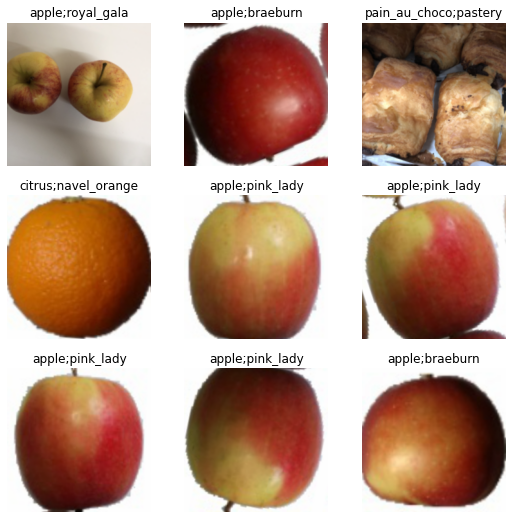

In [9]:
# Preview data
dls.show_batch()

In [10]:
# Init learner; use resnet50 as the starting point for this CNN
learn = cnn_learner(dls, resnet152, metrics=partial(accuracy_multi, thresh=0.5), model_dir='models')

In [11]:
# Calc optimal learning rate
#learn.lr_find()

In [12]:
# Train model
learn.fine_tune(10, 0.001)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.714036,0.477992,0.730556,18:12


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.528259,0.369425,0.812374,21:53
1,0.493481,0.341321,0.841667,22:04
2,0.443841,0.273694,0.924495,21:59
3,0.385139,0.205021,0.965151,21:29
4,0.314449,0.152302,0.988889,21:26
5,0.255156,0.115380,0.991919,21:24
6,0.204238,0.083225,0.995202,21:33
7,0.169534,0.079453,0.995202,21:58
8,0.146780,0.077403,0.995455,22:05
9,0.138176,0.073421,0.996212,22:04


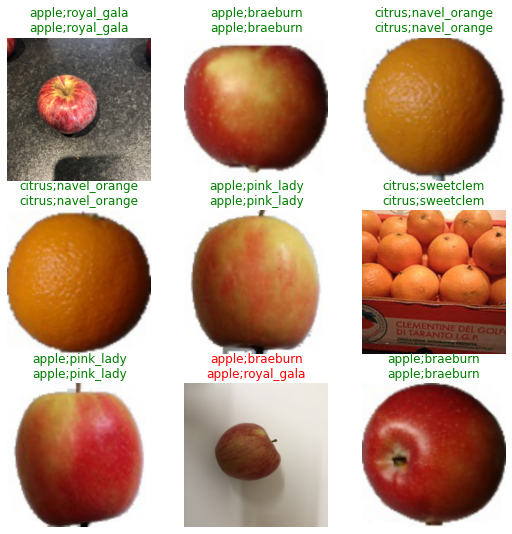

In [13]:
# Preview results
learn.show_results()

,target,predicted,probabilities,loss
0,apple;braeburn,apple;cosmic_crisp,"TensorBase([[9.9950e-01, 1.1856e-02, 5.3289e-04, 9.2864e-01, 1.1824e-01, 1.0176e-01,\n 5.2216e-04, 1.6042e-01, 5.6394e-02, 1.0329e-01, 7.5754e-02, 5.3266e-02],\n [9.9830e-01, 3.8165e-01, 2.1117e-03, 5.2362e-02, 8.2899e-02, 9.9912e-02,\n 7.2895e-04, 6.6858e-02, 3.6251e-02, 2.7707e-02, 9.6130e-01, 5.9725e-02],\n [9.9239e-01, 2.0039e-01, 1.3014e-02, 7.4350e-02, 1.6031e-01, 1.6273e-01,\n 3.0668e-03, 1.7530e-01, 8.3669e-02, 3.3838e-02, 5.5333e-01, 2.1260e-01],\n [9.9433e-01, 6.2325e-01, 5.2006e-03, 6.2937e-02, 9.7781e-02, 8.8763e-02,\n 6.0965e-04, 7.1171e-02, 5.2052e-02, 2.3163e-02, 8.6767e-01, 2.0937e-01],\n [9.9544e-01, 3.4271e-01, 3.4453e-03, 9.6373e-02, 1.8409e-01, 1.0943e-01,\n 4.3571e-03, 1.3344e-01, 9.7836e-02, 2.1891e-01, 4.3594e-01, 9.0932e-02],\n [9.9897e-01, 4.1527e-01, 5.8196e-04, 7.4447e-02, 1.4640e-01, 1.0128e-01,\n 1.0513e-03, 1.3075e-01, 8.7281e-02, 3.2184e-01, 7.4516e-01, 7.6754e-02],\n [9.9878e-01, 2.7657e-03, 2.0508e-03, 3.5736e-01, 2.0826e-01, 1.1380e-01,\n 3.8149e-03, 1.0110e-01, 9.4137e-02, 8.3858e-01, 6.3042e-01, 9.3371e-02],\n [9.9981e-01, 3.0112e-01, 1.4215e-03, 2.7418e-01, 1.6441e-01, 7.7658e-02,\n 3.0840e-04, 9.5588e-02, 5.0058e-02, 9.4717e-02, 4.7052e-01, 1.1687e-01],\n [8.6353e-07, 6.8563e-03, 6.7127e-05, 2.3289e-02, 9.2040e-02, 9.8537e-01,\n 6.3164e-04, 8.2557e-01, 1.0000e+00, 1.8426e-06, 9.2376e-02, 1.6247e-03]])",0.6487520337104797


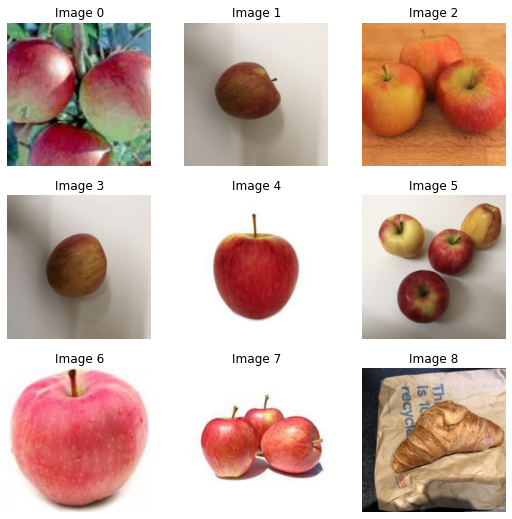

In [14]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

In [15]:
learn.save('model1.pkl')

Path('images/models/model1.pkl.pth')

In [18]:
learn.export()

In [17]:
learn.predict('images/12-12-2021_IMG_3855.JPEG')

((#2) ['crossiant_plain','pastery'],
 TensorBase([False, False, False, False, False,  True, False, False,  True, False,
         False, False]),
 TensorBase([1.3334e-03, 8.9088e-03, 2.1456e-03, 1.9111e-01, 3.9613e-01, 8.3383e-01,
         3.4244e-04, 4.4946e-01, 1.0000e+00, 8.9879e-05, 2.2881e-01, 1.4803e-01]))